In [8]:
%matplotlib inline


# Working with FITS files (opening, plotting, masking, fitting)

This is a document to introduce opening, parsing, plotting, masking, and fitting FITS files.
This example opens an image stored in a FITS file.

This example uses `astropy.utils.data` to download the file, `astropy.io.fits` to open
the file, and `matplotlib.pyplot` to display the image. Numpy is used for arrays and mathematics.

-------------------

*By: Troy Messina*

-------------------




Set up matplotlib, numpy, and astropy



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style) #This appears to have out of date functions (TCM 2/24/18)

Download an example FITS file used by this example and store it in "image_file" structure. This requires the download_file package. To open files from a local directory, use the get_pkg_data_filename package.


In [5]:
from astropy.utils.data import download_file
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

image_file = get_pkg_data_filename('cvf78701012.fits')
#image_file = download_file('https://physics.berea.edu/FITS/cvf78701012.fits',
#                           cache=True)

Use `astropy.io.fits.info()` to display the structure of the file:



In [6]:
fits.info(image_file)

Filename: cvf78701012.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1  DATA          1 BinTableHDU     44   151R x 10C   [1E, 1I, 1E, 1D, 1D, 1024E, 1024E, 1024E, 1024E, 1024E]   
  2  CUBE_PROJ     1 ImageHDU        29   (42, 42, 151)   float32   


Generally the image information is located in the Primary HDU, also known
as extension 0. Here, we use `astropy.io.fits.getdata()` to read the image
data from this second extension using the keyword argument ``ext=2``:



In [9]:
image_data = fits.getdata(image_file, ext=2)

### The data is now stored as a 2D array. Print the dimensions using the
shape attribute:



In [10]:
print(image_data.shape)

(151, 42, 42)


Let's punch through the data to see a spectrum. To do this pick a particular row and column of the 42x42 image. Then, grab all 150 spectral points.'

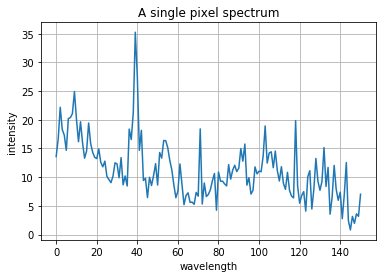

In [11]:
pixel0=image_data[:,20,10]
x = np.arange(0, 151, 1)

# Note that using plt.subplots below is equivalent to using
# fig = plt.figure and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()
ax.plot(x, pixel0)

ax.set(xlabel='wavelength', ylabel='intensity',
       title='A single pixel spectrum')
ax.grid()

#fig.savefig("test.png")
plt.show()

Ok, that works. So, we should be able to plot a matrix of spectra. There are 42x42 of them (1764). So, maybe we don't want to see all of them. Let's look at about 9 evenly spaced ones throughout the image. 

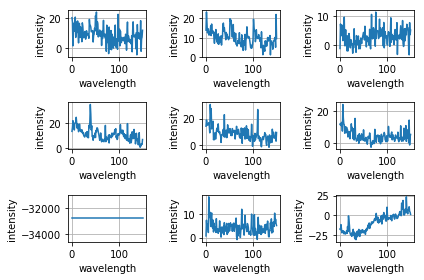

In [12]:
m = [[10,10],[10,20],[10,30],[20,10],[20,20],[20,30],[30,10],[30,20],[30,30]]

# Note that using plt.subplots below is equivalent to using
# fig = plt.figure and then ax = fig.add_subplot(111)
fig, axes = plt.subplots(nrows=3, ncols=3)

#axes[0, 0].set_title('Linear normalization')
#for i in axes.flat:
#    print(i)
    
for ax, (a,b) in zip(axes.flat[0:], m):
    #ax.set_title('row=' %a )
    ax.plot(x,image_data[:,a,b])
    ax.set(xlabel='wavelength', ylabel='intensity',
       title='')
    ax.grid()

fig.tight_layout()

plt.show()

That's pretty neat. We'll have to eventually see how to analyze each one. Now, let's get images from the array. These are the 42x42 dimensions. There should be one for each wavelength, frequency, or wavenumber (whatever units these things are). Display the image data:

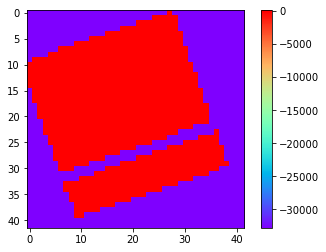

In [13]:
frame0 = image_data[0,:,:]
frame25 = image_data[24,:,:]
frame50 = image_data[49,:,:]
frame100 = image_data[99,:,:]

plt.figure()
plt.imshow(frame100, cmap='rainbow')
plt.colorbar()
plt.show()

In [14]:
print(type(frame0))
print(frame0.shape)

<class 'numpy.ndarray'>
(42, 42)


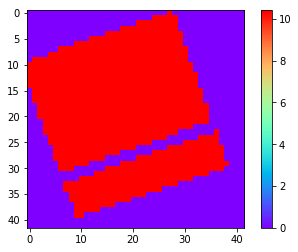

In [15]:
loggedframe = np.log(frame0+32769)
plt.show()
plt.imshow(loggedframe, cmap='rainbow')
plt.colorbar()

In [16]:
print('Min:', np.min(frame0))
print('Max:', np.max(frame0))
print('Mean:', np.mean(frame0))
print('Stdev:', np.std(frame0))

Min: -32768.0
Max: 94.9955
Mean: -15579.8
Stdev: 16369.7


In [17]:
np.savetxt("foo.csv", image_data, fmt='%s', delimiter=",")

Let's see how to select a region of interest. First, we'll create an identically sized matrix (42x42). As a first pass, lets mask with a binary mask. Eventually, we should functionalize this for circle, rectangle, Gaussian, etc. type masks.

263.232920945


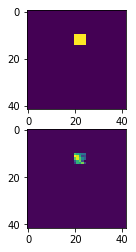

In [18]:
mask = np.zeros((42,42), dtype=float)
mask[10:15,20:25] = 1
masked_data = np.multiply(frame0, mask)
added = np.sum(masked_data)
print(added)

fig, (ax1, ax2) = plt.subplots(2)

ax1.imshow(mask)
ax2.imshow(masked_data)
plt.show()


 The masking works for the simple case of a rectangle. We need to create an array that stores the summed value of the mask as we punch through the spectral dimension, i.e., we need to mask 151 times and store the 151 data points in a spectrum array.

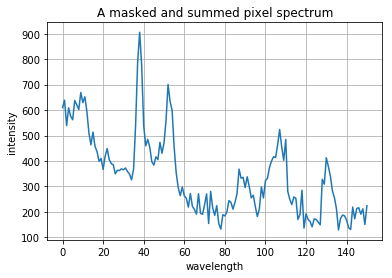

In [19]:
mask = np.zeros((42,42), dtype=float)
mask[10:15,10:15] = 1
spectrum = np.zeros(151)
for index in np.nditer(x):
    frame = image_data[index,:,:]
    masking = np.multiply(mask, frame)
    spectrum[index] = np.sum(masking)

fig, ax = plt.subplots()
ax.plot(x, spectrum)
ax.set(xlabel='wavelength', ylabel='intensity',
       title='A masked and summed pixel spectrum')
ax.grid()
plt.show()

What happens if we sum the entire 42x42 image and punch through the spectrum dimension?

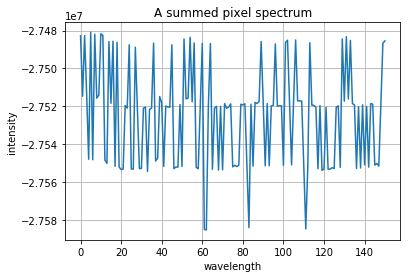

In [20]:
mask = np.ones((42,42), dtype=float)
spectrum = np.zeros(151)
for index in np.nditer(x):
    frame = image_data[index,:,:]
    masking = np.multiply(mask, frame)
    spectrum[index] = np.sum(masking)

fig, ax = plt.subplots()
ax.plot(x, spectrum)
ax.set(xlabel='wavelength', ylabel='intensity',
       title='A summed pixel spectrum')
ax.grid()
plt.show()

That's a bit weird. Let's get rid of negative values by masking them to zero.

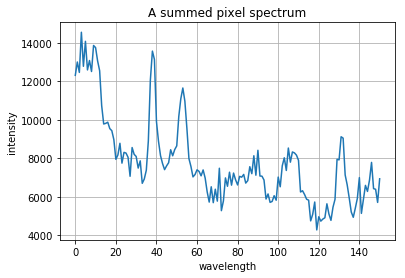

In [21]:
spectrum = np.zeros(151, dtype=float)
for index in np.nditer(x):
    frame = image_data[index,:,:]
    mask = np.ones((42,42), dtype=float)
    np.putmask(mask, frame<0, 0)
    masking = np.multiply(mask, frame)
    spectrum[index] = np.sum(masking)

fig, ax = plt.subplots()
ax.plot(x, spectrum)
ax.set(xlabel='wavelength', ylabel='intensity',
       title='A summed pixel spectrum')
ax.grid()
plt.show()

# Curve Fitting the Spectrum
Let's try some curve fitting. First we'll fit a polynomial to the background.
$$f(x) = ax^2+bx+c$$
We'll need a function that takes and x array, and a, b, c values.

Best fit: a= 0.447414925559  and b= -104.069170055  and c= 12275.8128063


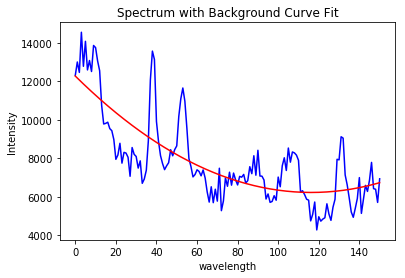

In [22]:
from scipy.optimize import curve_fit
#function takes an array of x values and returns an array of y values
#  where y=ax^2+bx+c
def func(x, a, b, c):
    return a*x*x+b*x+c #linear function

#do the curve fit
constants, stats = curve_fit(func, x, spectrum)

#constants is a list
abest=constants[0] #a
bbest=constants[1] #b
cbest=constants[2] #c
print("Best fit: a=",abest," and b=",bbest," and c=",cbest)
ybest=func(x,abest,bbest,cbest) #y values for best fit function

plt.title('Spectrum with Background Curve Fit')
plt.xlabel('wavelength')
plt.ylabel('Intensity')
plt.plot(x,spectrum,'b-',x,ybest,'r-')
plt.show()

Let's try fitting a peak with a Gaussian.

Best fit: a= 6247.52008674  , b= 38.245755161  , c= 1.30050103107  , d= 7702.54739942


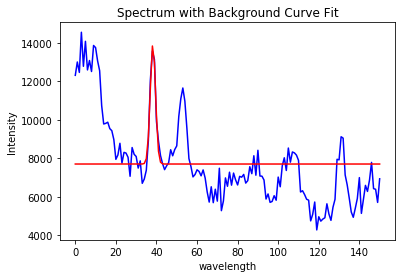

In [36]:
#function takes an array of x values and returns an array of y values
#  where y=ax^2+bx+c
def func(x, a, b, c, d):
    return a*np.exp(-0.5*((x-b)/c)**2)+d #linear function

#do the curve fit
initial_guess = np.array([10000,40,5,1000])
constants, stats = curve_fit(func, x, spectrum, p0=initial_guess)

#constants is a list
abest=constants[0] #a - amplitude
bbest=constants[1] #b - average
cbest=constants[2] #c - width
dbest=constants[3] #d - baseline
print("Best fit: a=",abest," , b=",bbest," , c=",cbest," , d=",dbest)
ybest=func(x,abest,bbest,cbest,dbest) #y values for best fit function

plt.title('Spectrum with Background Curve Fit')
plt.xlabel('wavelength')
plt.ylabel('Intensity')
plt.plot(x,spectrum,'b-',x,ybest,'r-')
plt.show()

## Two fit functions in one
Now, let's put the quadratic background together with the Gaussian.

Best fit:  [  4.10326576e+03   6.54443208e+00   5.62383400e+00   6.44174227e+03
   3.83065798e+01   1.39330353e+00   4.43534987e+03   5.27269117e+01
   2.72112518e+00   1.76863704e+03   8.60784601e+01   7.31820438e+00
   2.97547535e+03   1.06378921e+02   3.70923585e+00   3.51670992e+03
   1.31097840e+02  -1.62239381e+00   4.02184946e-01  -8.69857135e+01
   1.01498896e+04]


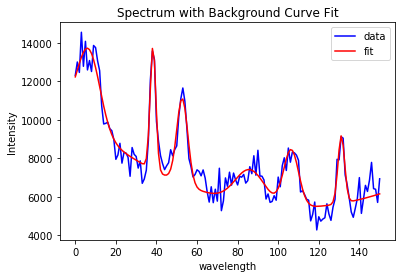

In [40]:
#function takes an array of x values and returns an array of y values
def twofunc(x, a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20):
    return a0*np.exp(-0.5*((x-a1)/a2)**2)+a3*np.exp(-0.5*((x-a4)/a5)**2)+a6*np.exp(-0.5*((x-a7)/a8)**2)+a9*np.exp(-0.5*((x-a10)/a11)**2)+a12*np.exp(-0.5*((x-a13)/a14)**2)+a15*np.exp(-0.5*((x-a16)/a17)**2)+a18*x*x+a19*x+a20

#do the curve fit
initial_guess = np.array([10000,10,5,10000,40,5,5000,50,5,5000,90,5,5000,105,5,5000,130,5,0.4, 10, 100])
ps, stats = curve_fit(twofunc, x, spectrum, p0=initial_guess)

#constants is a list
print("Best fit: ",ps)
ybest=twofunc(x,ps[0],ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12],ps[13],ps[14],ps[15],ps[16],ps[17],ps[18],ps[19],ps[20]) #y values for best fit function

plt.title('Spectrum with Background Curve Fit')
plt.xlabel('wavelength')
plt.ylabel('Intensity')
plt.plot(x,spectrum,'b-',label='data')
plt.plot(x,ybest,'r-',label='fit')
plt.legend()
#plt.savefig("fit1")
plt.show()